# This script contains the following:

- Importing libraries and data
- Subsetting, wrangling, and cleaning time-series data
- Time series analysis: decomposition
- Testing for stationarity
- Stationarizing the Federal Reserve Economic Data

In [3]:
#conda install quandl

# Import libraries & load dataset

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
# Define full absolute paths
path = r'/Users/macbook/Dropbox/Mac/Documents/Pro/Data Analyst/Course_Career foundry/A6_Data immersion/02_data'
file_path = os.path.join(path,'prepared_data','transactions_V4')

# Load file from pickle
df = pd.read_pickle(file_path)

# Subsetting, wrangling, and cleaning time-series data

In [6]:
df.shape

(7449536, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7449536 entries, 0 to 7810683
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id_transaction    int32         
 1   date_transaction  datetime64[ns]
 2   year              int64         
 3   price             float64       
 4   price_m2          float64       
 5   id_city           int32         
 6   city              object        
 7   postcode          int32         
 8   adresse           object        
 9   departement       object        
 10  building_type     object        
 11  vefa              bool          
 12  n_rooms           int32         
 13  living_area       int32         
 14  latitude          float64       
 15  longitude         float64       
dtypes: bool(1), datetime64[ns](1), float64(4), int32(5), int64(1), object(4)
memory usage: 774.4+ MB


In [8]:
# check dataframe
des = round(df.describe())
des

,id_transaction,date_transaction,year,price,price_m2,id_city,postcode,n_rooms,living_area,latitude,longitude
count,7449536.0,7449536,7449536.0,7449536.0,7449536.0,7449536.0,7449536.0,7449536.0,7449536.0,7449536.0,7449536.0
mean,6723584.0,2018-10-24 23:29:56.644301056,2018.0,219058.0,2925.0,209.0,53295.0,4.0,82.0,46.0,2.0
min,2.0,2014-01-01 00:00:00,2014.0,5500.0,577.0,1.0,1000.0,0.0,9.0,-21.0,-63.0
25%,3306694.0,2016-10-06 00:00:00,2016.0,112000.0,1548.0,71.0,31300.0,2.0,53.0,45.0,1.0
50%,6686340.0,2018-12-14 00:00:00,2018.0,171000.0,2353.0,167.0,56400.0,3.0,76.0,47.0,2.0
75%,10182264.0,2020-12-23 00:00:00,2020.0,262000.0,3594.0,300.0,77127.0,4.0,101.0,49.0,5.0
max,13067339.0,2022-12-31 00:00:00,2022.0,17865830.0,14100.0,909.0,97490.0,112.0,1640.0,51.0,56.0
std,3899116.0,NaN,2.0,191507.0,2079.0,173.0,27687.0,2.0,42.0,6.0,6.0


### Note: Outliers in the price variable
We see a very high price of 17 865 830€. let's check the outliers & potential errors with this variable

## Process the outliers for the "price" variable.

In [9]:
df_out = df[(df['price']> 2000000)]
df_out.tail()

,id_transaction,date_transaction,year,price,price_m2,id_city,city,postcode,adresse,departement,building_type,vefa,n_rooms,living_area,latitude,longitude
7760417,12655942,2021-05-21,2021,2750000.0,7255.936675,22,ROBERT,97231,49 MTE MONTEE DU CLAPOTAGE,972,Maison,False,9,379,14.707249,-60.915001
7788090,12850494,2018-07-24,2018,2300000.0,8070.175439,11,SAINT DENIS,97400,5 ALL DES DIAMANTS,974,Maison,False,7,285,-20.901909,55.445760
7800713,12722947,2020-12-29,2020,2531100.0,7670.000000,15,SAINT-PAUL,97434,6T AV DE BOURBON,974,Maison,False,8,330,-21.061739,55.222177
7810187,12600424,2022-09-30,2022,2200000.0,8029.197080,11,SAINT DENIS,97400,47 RUE FELIX GUYON,974,Maison,False,8,274,-20.880358,55.451685
7810398,12601100,2022-11-14,2022,2300000.0,9200.000000,22,LE TAMPON,97430,184 RUE MARIUS ET ARY LEBLOND,974,Maison,False,8,250,-21.281528,55.524704


when filtering high values in 'prices', we see that the lot are in French overseas territories like Guadeloupe. Let's filter only those departement.

In [10]:
# filter the entire dataframe with only overseas territories
oversea = df[df['departement'] > "95"]  # in Mainland, the highest departement is 95
round(oversea.describe())

,id_transaction,date_transaction,year,price,price_m2,id_city,postcode,n_rooms,living_area,latitude,longitude
count,72669.0,72669,72669.0,72669.0,72669.0,72669.0,72669.0,72669.0,72669.0,72669.0,72669.0
mean,12829448.0,2018-09-22 16:25:57.527969024,2018.0,196494.0,2684.0,14.0,97333.0,3.0,75.0,-5.0,3.0
min,12592362.0,2014-01-02 00:00:00,2014.0,8880.0,578.0,1.0,97100.0,0.0,9.0,-21.0,-63.0
25%,12717124.0,2016-09-12 00:00:00,2016.0,103000.0,1794.0,9.0,97220.0,2.0,48.0,-21.0,-61.0
50%,12844371.0,2018-11-16 00:00:00,2018.0,165000.0,2462.0,13.0,97400.0,3.0,69.0,-21.0,55.0
75%,12964055.0,2020-11-30 00:00:00,2020.0,250000.0,3297.0,18.0,97432.0,4.0,94.0,15.0,55.0
max,13067339.0,2022-12-30 00:00:00,2022.0,2750000.0,13889.0,62.0,97490.0,62.0,494.0,18.0,56.0
std,145125.0,NaN,2.0,141624.0,1342.0,8.0,125.0,1.0,38.0,17.0,57.0


Text(0.5, 1.0, 'Boxplot of Price Distribution')

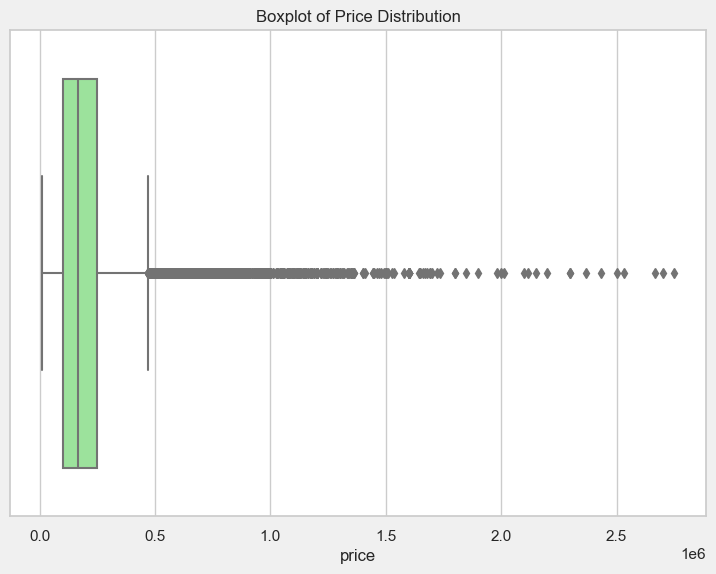

In [10]:
# Create a boxplot for overseas territories
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.set(style="whitegrid")

sns.boxplot(x=oversea['price'], color='lightgreen')

# Add labels and a title
plt.xlabel('price')
plt.title('Boxplot of Price Distribution')

there is also a lot of outliers. we will remove those values and focus on mainland anyway

# Removing Overseas territories from analysis


In [11]:
df = df[df['postcode'] <= 96000]
round(df.describe())

,id_transaction,date_transaction,year,price,price_m2,id_city,postcode,n_rooms,living_area,latitude,longitude
count,7376867.0,7376867,7376867.0,7376867.0,7376867.0,7376867.0,7376867.0,7376867.0,7376867.0,7376867.0,7376867.0
mean,6663436.0,2018-10-25 07:08:03.094354176,2018.0,219281.0,2927.0,211.0,52862.0,4.0,82.0,47.0,2.0
min,2.0,2014-01-01 00:00:00,2014.0,5500.0,577.0,1.0,1000.0,0.0,9.0,42.0,-5.0
25%,3276928.0,2016-10-06 00:00:00,2016.0,112000.0,1546.0,73.0,31260.0,2.0,54.0,45.0,1.0
50%,6570900.0,2018-12-14 00:00:00,2018.0,171000.0,2352.0,170.0,56120.0,3.0,76.0,47.0,2.0
75%,10105550.0,2020-12-23 00:00:00,2020.0,262000.0,3600.0,301.0,76600.0,4.0,101.0,49.0,5.0
max,13054418.0,2022-12-31 00:00:00,2022.0,17865830.0,14100.0,909.0,95880.0,112.0,1640.0,51.0,8.0
std,3870632.0,NaN,2.0,191921.0,2085.0,173.0,27474.0,2.0,42.0,2.0,3.0


we still have lot of high price values. let's keep digging if it's error or not

In [12]:
round(df['postcode'].describe())

count    7376867.0
mean       52862.0
std        27474.0
min         1000.0
25%        31260.0
50%        56120.0
75%        76600.0
max        95880.0
Name: postcode, dtype: float64

In [31]:
# Define the target column and the IQR constant (e.g., 1.5 or 3)
target_column = 'price'
iqr_constant = 1.5

# Calculate the IQR for the target column
Q1 = df[target_column].quantile(0.25)
Q3 = df[target_column].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - iqr_constant * IQR
upper_bound = Q3 + iqr_constant * IQR

# Remove outliers by filtering the DataFrame
filtered_df = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]

# Display the DataFrame with outliers removed
print("DataFrame with outliers removed:")
print(filtered_df)



DataFrame with outliers removed:
         id_transaction date_transaction  year     price     price_m2  \
0                332948       2014-01-02  2014  173020.0  2403.055556   
1                328900       2014-01-02  2014  157500.0  1529.126214   
2                326170       2014-01-02  2014  112000.0  1435.897436   
3                328585       2014-01-02  2014  197000.0  2345.238095   
4                335040       2014-01-03  2014  126000.0  1135.135135   
...                 ...              ...   ...       ...          ...   
7733816        12589002       2022-12-30  2022  300000.0  4411.764706   
7733817        12590529       2022-12-30  2022  330000.0  5322.580645   
7733818        12588446       2022-12-30  2022  230000.0  3593.750000   
7733820        12591045       2022-12-30  2022  136500.0  3900.000000   
7733821        12589083       2022-12-30  2022  110000.0  2894.736842   

         id_city                     city  postcode  \
0            202                  L

In [32]:
round(filtered_df.describe())

,id_transaction,date_transaction,year,price,price_m2,id_city,postcode,n_rooms,living_area,latitude,longitude
count,6917342.0,6917342,6917342.0,6917342.0,6917342.0,6917342.0,6917342.0,6917342.0,6917342.0,6917342.0,6917342.0
mean,6564318.0,2018-10-11 09:21:53.456758272,2018.0,183391.0,2674.0,214.0,52162.0,3.0,79.0,47.0,2.0
min,2.0,2014-01-01 00:00:00,2014.0,5500.0,577.0,1.0,1000.0,0.0,9.0,42.0,-5.0
25%,3217991.0,2016-09-23 00:00:00,2016.0,108606.0,1500.0,76.0,31140.0,2.0,52.0,45.0,1.0
50%,6340702.0,2018-11-27 00:00:00,2018.0,164000.0,2241.0,174.0,54130.0,3.0,74.0,47.0,2.0
75%,9986710.0,2020-12-14 00:00:00,2020.0,240000.0,3336.0,306.0,76310.0,4.0,98.0,49.0,5.0
max,13054418.0,2022-12-31 00:00:00,2022.0,487000.0,14099.0,909.0,95880.0,112.0,827.0,51.0,8.0
std,3844450.0,NaN,2.0,99489.0,1744.0,173.0,27283.0,1.0,38.0,2.0,3.0


Text(0.5, 1.0, 'Boxplot of Price Distribution')

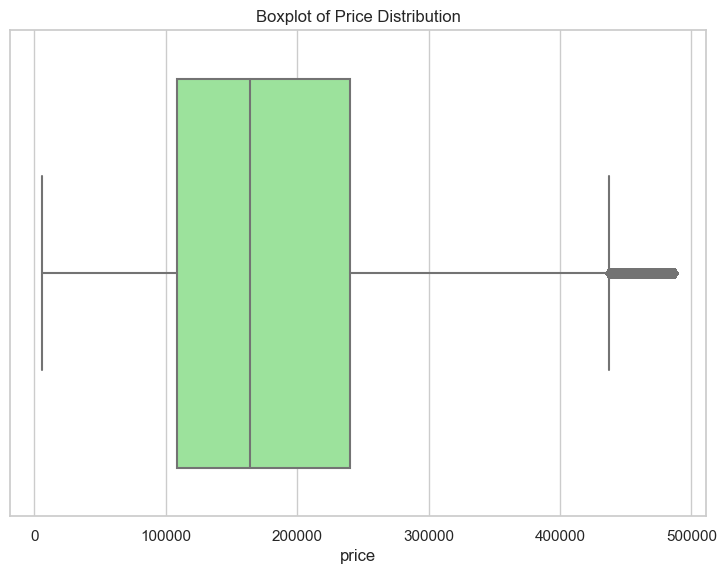

In [33]:
# Create a boxplot for prices
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.set(style="whitegrid")

sns.boxplot(x=filtered_df['price'], color='lightgreen')

# Add labels and a title
plt.xlabel('price')
plt.title('Boxplot of Price Distribution')

Now let's do the same for the number of rooms variable

<Axes: xlabel='n_rooms'>

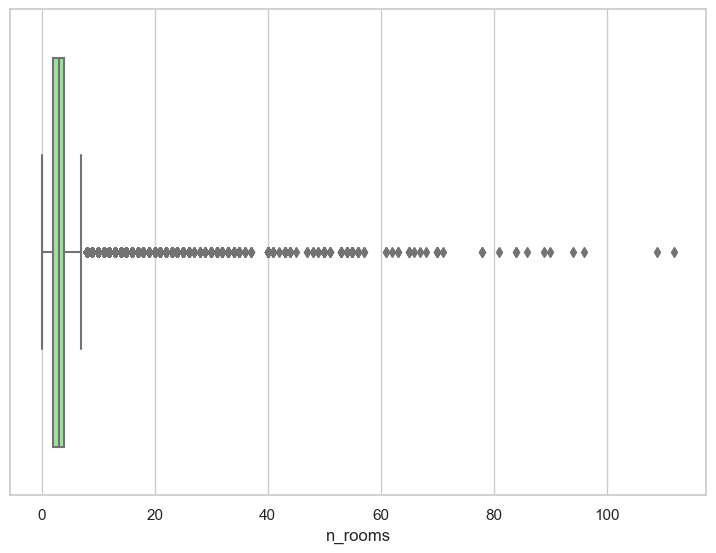

In [34]:
# Create a boxplot for prices
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.set(style="whitegrid")

sns.boxplot(x=filtered_df['n_rooms'], color='lightgreen')


In [47]:
# Define the target column and the IQR constant (e.g., 1.5 or 3)
target_column = 'n_rooms'
iqr_constant = 1.5

# Calculate the IQR for the target column
Q1 = df[target_column].quantile(0.25)
Q3 = df[target_column].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - iqr_constant * IQR
upper_bound = Q3 + iqr_constant * IQR

# Remove outliers by filtering the DataFrame
filtered_df =filtered_df[(filtered_df[target_column] >= lower_bound) & (filtered_df[target_column] <= upper_bound)]

<Axes: xlabel='n_rooms'>

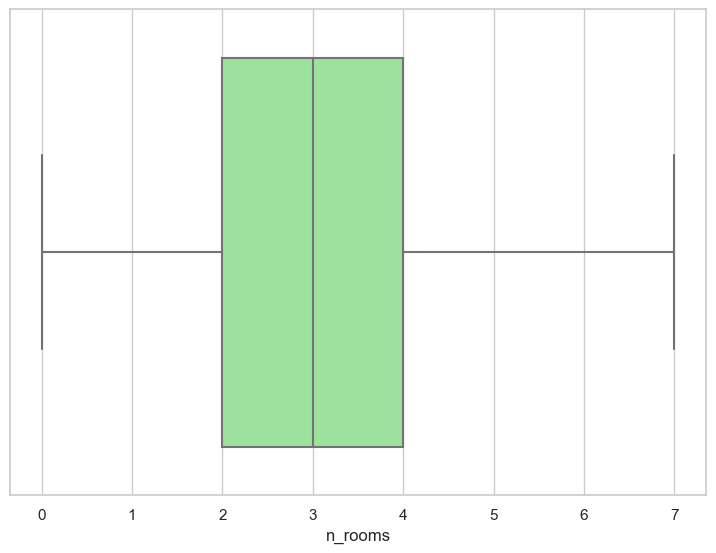

In [48]:
# Create a boxplot for n_rooms
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.set(style="whitegrid")

sns.boxplot(x=filtered_df['n_rooms'], color='lightgreen')


Better. now let's also do it for living_area

In [49]:
# Define the target column and the IQR constant (e.g., 1.5 or 3)
target_column = 'living_area'
iqr_constant = 1.5

# Calculate the IQR for the target column
Q1 = df[target_column].quantile(0.25)
Q3 = df[target_column].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - iqr_constant * IQR
upper_bound = Q3 + iqr_constant * IQR

# Remove outliers by filtering the DataFrame
filtered_df = filtered_df[(filtered_df[target_column] >= lower_bound) & (filtered_df[target_column] <= upper_bound)]

<Axes: xlabel='living_area'>

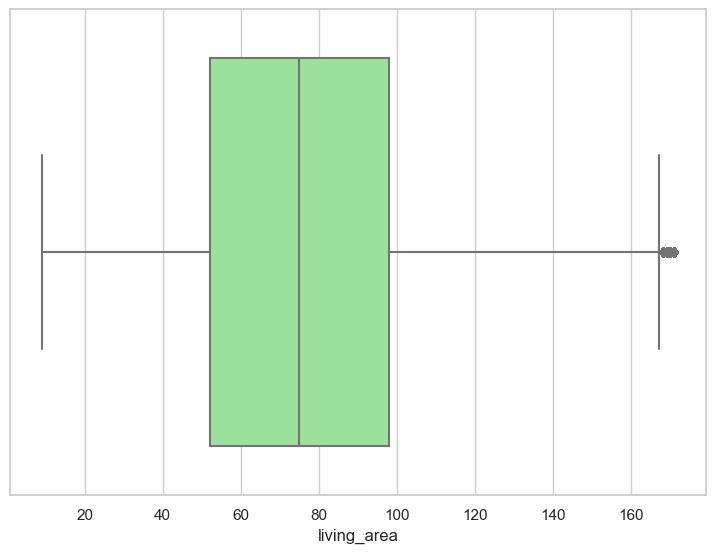

In [50]:
# Create a boxplot for n_rooms
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.set(style="whitegrid")

sns.boxplot(x=filtered_df['living_area'], color='lightgreen')


Let's check our data set now

In [51]:
round(filtered_df.describe())

,id_transaction,date_transaction,year,price,price_m2,id_city,postcode,n_rooms,living_area,latitude,longitude
count,7114403.0,7114403,7114403.0,7114403.0,7114403.0,7114403.0,7114403.0,7114403.0,7114403.0,7114403.0,7114403.0
mean,6676807.0,2018-10-22 10:45:39.448862208,2018.0,208280.0,2944.0,210.0,52948.0,3.0,77.0,47.0,2.0
min,2.0,2014-01-01 00:00:00,2014.0,5500.0,577.0,1.0,1000.0,0.0,9.0,42.0,-5.0
25%,3285902.0,2016-10-03 00:00:00,2016.0,110000.0,1562.0,73.0,31270.0,2.0,52.0,45.0,1.0
50%,6590227.0,2018-12-11 00:00:00,2018.0,168000.0,2372.0,169.0,56220.0,3.0,75.0,47.0,2.0
75%,10121580.0,2020-12-22 00:00:00,2020.0,254000.0,3617.0,301.0,76620.0,4.0,98.0,49.0,5.0
max,13054418.0,2022-12-31 00:00:00,2022.0,2400000.0,14100.0,909.0,95880.0,7.0,171.0,51.0,8.0
std,3876658.0,NaN,2.0,161287.0,2085.0,172.0,27517.0,1.0,33.0,2.0,3.0


In [52]:
filtered_df.shape

(7114403, 16)

So we used the IQR range technique to get rid of outliers within the price, n_rooms & living_area variables.
Our dataset is still populated with 7 114 403 records, giving us a large enough dataset to study.

#  Subsetting, wrangling, and cleaning time-series data

In [59]:
# define an easier name
df_2 = filtered_df

In [ ]:
# Reset index so that you can use the "Date" column as a filter
#df_2 = df_2.reset_index()


In [84]:
df_2.head()

,id_transaction,date_transaction,year,price,price_m2,id_city,city,postcode,adresse,departement,building_type,vefa,n_rooms,living_area,latitude,longitude
0,332948,2014-01-02,2014,173020.0,2403.055556,202,LAGNIEU,1150,21 GR GRANDE RUE DE BULLIEZ,01,Maison,False,4,72,45.899056,5.354210
1,328900,2014-01-02,2014,157500.0,1529.126214,451,VIRIAT,1440,1369 RTE DE STRASBOURG,01,Maison,False,4,103,46.236407,5.262935
2,326170,2014-01-02,2014,112000.0,1435.897436,365,SAINT-JEAN-SUR-VEYLE,1290,5174 SAINT JEAN SUR VEYLE,01,Maison,False,3,78,46.260087,4.918587
3,328585,2014-01-02,2014,197000.0,2345.238095,427,TREVOUX,1600,6346 MTE DES LILAS,01,Appartement,False,4,84,45.942301,4.770694
4,335040,2014-01-03,2014,126000.0,1135.135135,283,OYONNAX,1100,29B RUE DE LA FORGE,01,Appartement,False,4,111,46.258411,5.640810


In [83]:
# Using 7 years scope is enough to have a look on the market
df_sub = df_2.loc[(df_2['date_transaction'] >= '2016-01-01') & (df_2['date_transaction'] < '2022-12-31')]


In [85]:
df_sub.head()

,id_transaction,date_transaction,year,price,price_m2,id_city,city,postcode,adresse,departement,building_type,vefa,n_rooms,living_area,latitude,longitude
12364,262223,2016-01-01,2016,130000.0,878.378378,22,ARTEMARE,1510,4 ALL DE L'EGLISE,01,Maison,False,6,148,45.875214,5.691085
12365,267781,2016-01-04,2016,211000.0,2482.352941,93,CHATILLON-SUR-CHALARONNE,1400,5099 DOMAINE COURTOIS,01,Maison,False,5,85,46.146959,4.950677
12366,265409,2016-01-04,2016,140000.0,1228.070175,53,BOURG-EN-BRESSE,1000,9B RUE CREVE COEUR,01,Appartement,False,4,114,46.208882,5.223372
12367,266230,2016-01-04,2016,243700.0,2175.892857,34,BELLEY,1300,90 RUE DU 5EME RTM,01,Appartement,False,4,112,45.760845,5.690080
12368,261461,2016-01-04,2016,203700.0,2078.571429,50,BOISSEY,1190,5149 AU BOURG,01,Maison,False,4,98,46.383599,4.996789


In [86]:
# Set the "Date" column as the index

from datetime import datetime

#df_sub['datetime'] = pd.to_datetime(df_sub['date_transaction']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('date_transaction') # Set the datetime as the index of the dataframe.
#df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.


df_sub.head()

,id_transaction,year,price,price_m2,id_city,city,postcode,adresse,departement,building_type,vefa,n_rooms,living_area,latitude,longitude
date_transaction,,,,,,,,,,,,,,,
2016-01-01,262223,2016,130000.0,878.378378,22,ARTEMARE,1510,4 ALL DE L'EGLISE,01,Maison,False,6,148,45.875214,5.691085
2016-01-04,267781,2016,211000.0,2482.352941,93,CHATILLON-SUR-CHALARONNE,1400,5099 DOMAINE COURTOIS,01,Maison,False,5,85,46.146959,4.950677
2016-01-04,265409,2016,140000.0,1228.070175,53,BOURG-EN-BRESSE,1000,9B RUE CREVE COEUR,01,Appartement,False,4,114,46.208882,5.223372
2016-01-04,266230,2016,243700.0,2175.892857,34,BELLEY,1300,90 RUE DU 5EME RTM,01,Appartement,False,4,112,45.760845,5.690080
2016-01-04,261461,2016,203700.0,2078.571429,50,BOISSEY,1190,5149 AU BOURG,01,Maison,False,4,98,46.383599,4.996789


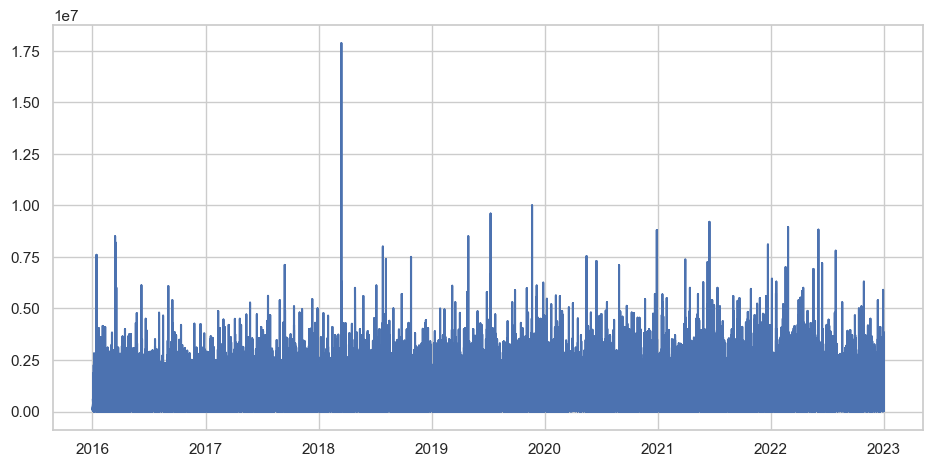

In [88]:
# Plot the new data set

plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_sub['price'])

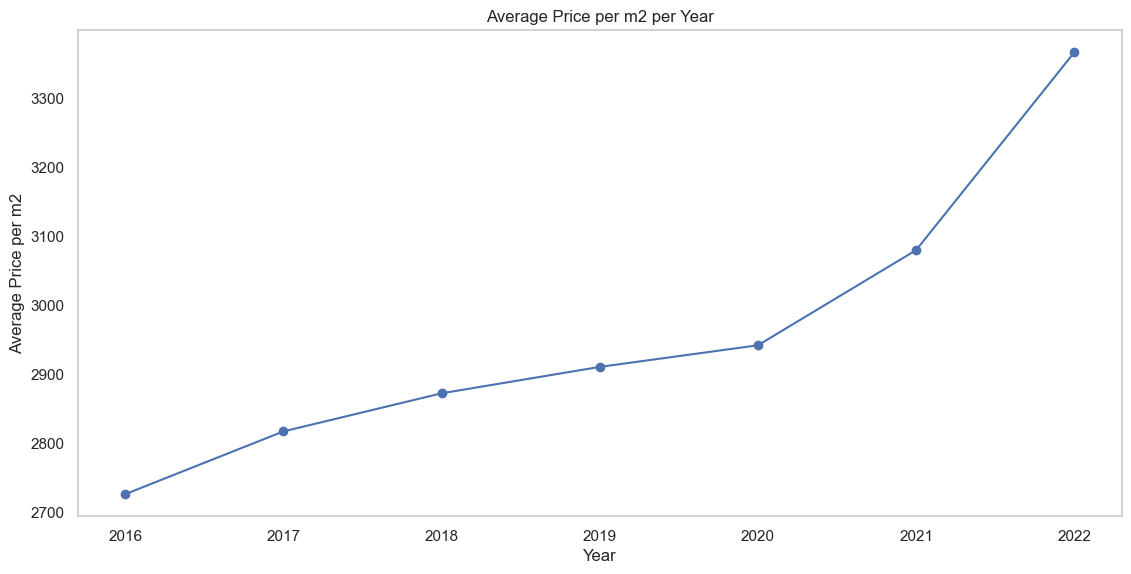

In [94]:
# Group the data by 'year' and calculate the mean of 'price_m2' for each year
df_grouped = df_sub.groupby('year')['price_m2'].mean()

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-', color='b')
plt.title('Average Price per m2 per Year')
plt.xlabel('Year')
plt.ylabel('Average Price per m2')
plt.grid(False)

# Export

In [104]:
df_sub.to_csv(os.path.join(path,'prepared_data','transactionsV5_cleaned.csv'))